In [214]:
import yfinance as yf
import pandas as pd
from pypfopt import EfficientFrontier
from pypfopt.expected_returns import ema_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt import objective_functions
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from tqdm.notebook import trange, tqdm
from pypfopt import HRPOpt
from pypfopt import expected_returns

import warnings
warnings.filterwarnings('ignore')

In [215]:
# Define the tickers and date range
# tickers = ["CGL.TO", "XUS.TO", "XGB.TO", "RY.TO", "WMT", "JNJ", "AAPL", "V", "TSLA", "BRK-B", "NVDA", "BLK", "CIS", "DIS", "AMD", "GOOG", "AMZN", "MSFT"]  
tickers = ["CGL.TO",  # iShares Gold Bullion ETF (CAD-Hedged)
           "HBD.TO",  # BetaPro Gold Bullion -2x Daily Bear ETF
           "VFV.TO",  # Vanguard S&P 500 Index ETF
           "HIU.TO",  # BetaPro S&P 500 Daily Inverse ETF
           "XGB.TO",  # iShares Core Canadian Government Bond Index ETF
           "XEQT.TO", # iShares Core Equity ETF Portfolio
           "ENB.TO",  # Enbridge Inc.
           "RY.TO",   # Royal Bank of Canada
           "WMT",     # Walmart Inc.
           "AAPL",    # Apple Inc.
           "V",       # Visa Inc.
           "MA",      # Mastercard Inc.
           "MSFT",    # Microsoft Corporation
           "BRK-B",   # Berkshire Hathaway Inc.
           "TSLA",    # Tesla Inc.
           "NVDA",    # NVIDIA Corporation
           "AMD",     # Advanced Micro Devices Inc.
           "BLK",     # BlackRock Inc.
           "JPM",     # JPMorgan Chase & Co.
           ]  

sector_mapper = {
    "CGL.TO": "Commodities",
    "HBD.TO": "Commodities",
    "VFV.TO": "Equity Index",
    "HIU.TO": "Equity Index",
    "XGB.TO": "Fixed Income",
    "XEQT.TO": "Multi-Asset",
    "ENB.TO": "Energy",
    "RY.TO": "Financials",
    "WMT": "Consumer Staples",
    "AAPL": "Technology",
    "V": "Financials",
    "MA": "Financials",
    "MSFT": "Technology",
    "BRK-B": "Financials",
    "TSLA": "Risky",
    "NVDA": "Risky",
    "AMD": "Risky",
    "BLK": "Financials",
    "JPM": "Financials"
}

# "Equity Index": 0.25,
# "Commodities": 0.10,
# "Multi-Asset": 0.25,

sector_lower = {
    "Equity Index": 0.25,
    "Commodities": 0.10,
    "Multi-Asset": 0.25,
}  

sector_upper = {
    "Risky": 0.25, 
}

# tickers_CAD = [
#            "CGL.TO",  # iShares Gold Bullion ETF (CAD-Hedged)
#            "HBD.TO",  # BetaPro Gold Bullion -2x Daily Bear ETF
#            "VFV.TO",  # Vanguard S&P 500 Index ETF
#            "HIU.TO",  # BetaPro S&P 500 Daily Inverse ETF
#            "XGB.TO",  # iShares Core Canadian Government Bond Index ETF
#            "XEQT.TO", # iShares Core Equity ETF Portfolio
#            "ENB.TO",  # Enbridge Inc.
#            "RY.TO",   # Royal Bank of Canada
#            "WMT.NE",  # Walmart Inc.
#            "APLY.NE", # Apple Inc.
#            "VISA.NE", # Visa Inc.
#            "MSFT.NE", # Microsoft Corporation 
#            "BRK.NE",  # Berkshire Hathaway Inc.
#            "TSLA.NE", # Tesla Inc.
#            "NVDA.NE", # NVIDIA Corporation
#            "AMD.NE",  # Advanced Micro Devices Inc.
#            "BLK.NE",  # BlackRock Inc.
#            ]  

start_date = "2017-01-03"
end_date = "2023-08-04"  # Today's date or last available date
# Fetch data from Yahoo Finance
data = yf.download(tickers, start=start_date, end=end_date)
# Extract the 'Close' prices
prices = data['Close']

# Add all missing dates
all_dates = pd.date_range(start_date, end_date)
prices = prices.reindex(all_dates)

# Fill NaN value with previous date value
prices = prices.fillna(method='ffill')

[*********************100%%**********************]  19 of 19 completed


In [216]:
# prices.to_csv('prices.csv')

In [217]:
initial_investment_amount = 100000
investment_starting_date = "2023-01-01"

# Get a dataframe of portfolio value of only investing in S&P500 (XUS.TO)
sp500 = prices['VFV.TO']
sp500 = sp500[sp500.index >= investment_starting_date]
sp500 = sp500 / sp500.iloc[0] * initial_investment_amount

In [218]:
def get_optimal_allocation(date, prices, total_portfolio_value, if_hrp=False, if_min_volatility=False):
    """
    Calculate the optimal allocation based on the given parameters.
    
    :param date: Date to calculate the optimal allocation
    :param prices: DataFrame of historical prices
    :param total_portfolio_value: Current total portfolio value
    :param if_hrp: 
    :param if_min_volatility: 
    :return: Dictionary of allocations and leftover cash
    """
    # Ensure the index is in the correct format
    prices.index = pd.to_datetime(prices.index)

    # Filter the prices based on the date range
    prices = prices.loc[:date]

    if if_hrp:
        mu = expected_returns.returns_from_prices(prices)

        hrp = HRPOpt(mu)
        
        # Add sector constraints
        hrp.add_sector_constraints(sector_mapper, sector_lower, sector_upper)

        hrp.optimize()

        cleaned_weights = hrp.clean_weights()

        # Get portfolio performance metrics
        expected_annual_return, annual_volatility, sharpe_ratio = hrp.portfolio_performance()
    else:
        # Calculate expected returns and sample covariance matrix
        # mu = ema_historical_return(prices, frequency=252)
        mu = expected_returns.mean_historical_return(prices)
        
        S = CovarianceShrinkage(prices).ledoit_wolf()

        # Optimize the portfolio
        ef = EfficientFrontier(mu, S)

        # Add L2 regularization to the optimization problem
        ef.add_objective(objective_functions.L2_reg, gamma=0.1)
        
        # Add sector constraints
        ef.add_sector_constraints(sector_mapper, sector_lower, sector_upper)
        
        if if_min_volatility:
            weights = ef.min_volatility()  # Uncomment this line if you prefer min volatility
        else:
            weights = ef.max_sharpe()
        

        # Get the discrete allocation of each asset
        cleaned_weights = ef.clean_weights()

        # Get portfolio performance metrics
        expected_annual_return, annual_volatility, sharpe_ratio = ef.portfolio_performance()

    # Get the latest prices
    latest_prices = get_latest_prices(prices)

    # Calculate the discrete allocation
    da = DiscreteAllocation(cleaned_weights, latest_prices, total_portfolio_value=total_portfolio_value)
    allocation, leftover = da.lp_portfolio()

    # Fill the tickers that are not in the allocation with 0
    for ticker in tickers:
        if ticker not in allocation:
            allocation[ticker] = 0

    return {
        'allocation': allocation,
        'leftover': leftover,
        'weights': cleaned_weights,
        'expected_annual_return': expected_annual_return,
        'annual_volatility': annual_volatility,
        'sharpe_ratio': sharpe_ratio,
    }


In [219]:
# Create a MVO dataframe with current portfolio value, all elements from the tickers, and left over cash columns
date_range = pd.date_range(investment_starting_date, end_date)
mvo = pd.DataFrame(index=date_range, columns=['Portfolio Value', 'Leftover Cash', 'isError'] + tickers)

# Initialize the portfolio
portfolio_value = initial_investment_amount
previous_allocation = pd.Series(0, index=tickers)
previous_leftover_cash = initial_investment_amount

In [220]:
# Iterate from the investment_starting_date to the end_date
for date in tqdm(date_range):
    # If the date is not a trading day, skip it
    if date not in prices.index:
        continue
    
    # Calculate the current portfolio value
    if date == pd.to_datetime(investment_starting_date):
        portfolio_value = initial_investment_amount
    else:
        price_at_date = prices.loc[date]
        portfolio_value = (price_at_date * previous_allocation).sum() + previous_leftover_cash
    
    # re-balance every Wednesday
    if date.weekday() != 2:
        try:
            # Get the optimal allocation
            allocation = get_optimal_allocation(date, prices, portfolio_value, if_hrp=False, if_min_volatility=False)
            mvo.loc[date, 'isError'] = False
        except Exception as e:
            # Use the same allocation as the previous day if an error occurs
            allocation = {
                'allocation': previous_allocation,
                'leftover': previous_leftover_cash
            }
            mvo.loc[date, 'isError'] = True
            print(e)
    else:
        # Use the same allocation as the previous day if it is not Wednesday
        mvo.loc[date, 'isError'] = False
        allocation = {
            'allocation': previous_allocation,
            'leftover': previous_leftover_cash
        }
    
    # Update the DataFrame
    mvo.loc[date, 'Portfolio Value'] = portfolio_value
    mvo.loc[date, tickers] = [allocation['allocation'].get(ticker, 0) for ticker in tickers]
    mvo.loc[date, 'Leftover Cash'] = allocation['leftover']
    
    # Update previous allocation and leftover cash for the next iteration
    # Convert the previous allocation to a Series to match the tickers
    previous_allocation = pd.Series(allocation['allocation'])
    previous_leftover_cash = allocation['leftover']
    

  0%|          | 0/216 [00:00<?, ?it/s]

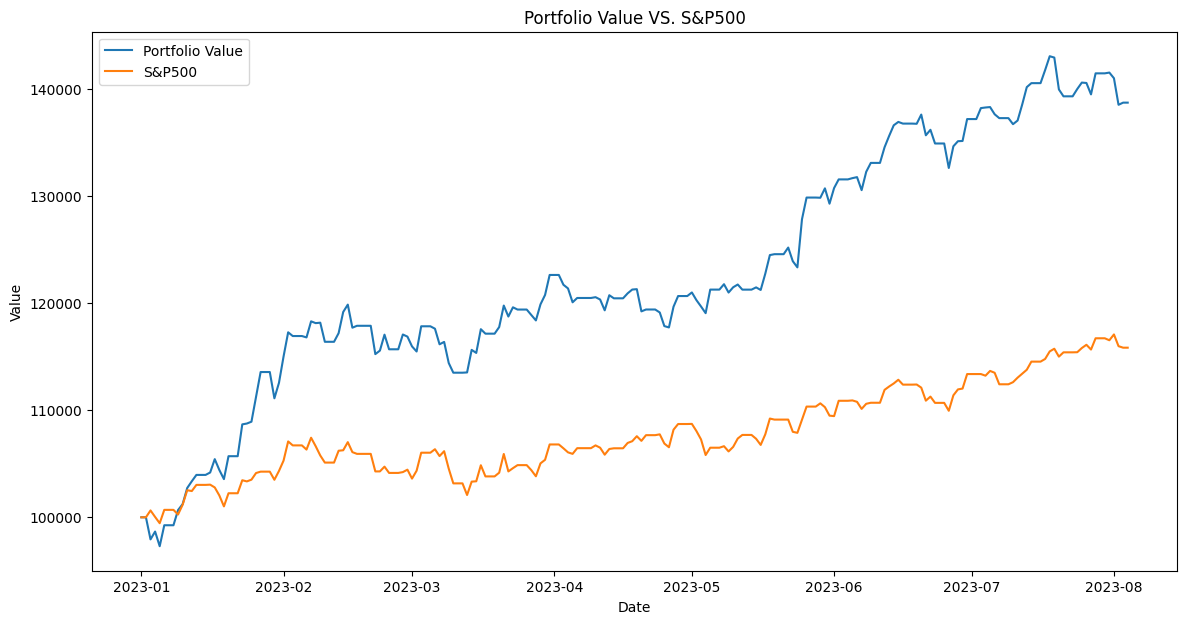

In [221]:
# Plot the portfolio value VS. S&P500
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

plt.plot(mvo['Portfolio Value'], label='Portfolio Value')
plt.plot(sp500, label='S&P500')
plt.title('Portfolio Value VS. S&P500')
plt.xlabel('Date')
plt.ylabel('Value')

plt.legend()
plt.show()


In [222]:
mvo.to_csv('mvo.csv')